In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql.functions import col, mean

In [22]:
# Initialize Spark Session
spark = SparkSession.builder.appName('Streaming_Analysis_With_Batch_Processing').getOrCreate()

In [23]:
schema = StructType([
    StructField("Request ID", IntegerType(), True),
    StructField("Num Clients", IntegerType(), True),
    StructField("Bottleneck Bandwidth", IntegerType(), True),
    StructField("Bottleneck Latency", FloatType(), True),
    StructField("Bottleneck Packet Loss", StringType(), True),
    StructField("Dash Policy", IntegerType(), True),
    StructField("Client Resolution", IntegerType(), True),
    StructField("Request Duration", IntegerType(), True),
    StructField("TCP Output Packet", FloatType(), True),
    StructField("TCP Output Delay", FloatType(), True),
    StructField("TCP Output Jitter", FloatType(), True),
    StructField("TCP Output Packet Loss", IntegerType(), True),
    StructField("TCP Input Packet", FloatType(), True),
    StructField("TCP Input Delay", FloatType(), True),
    StructField("TCP Input Jitter", FloatType(), True),
    StructField("TCP Input Packet Loss", IntegerType(), True),
    StructField("TCP Input Retransmission", FloatType(), True),
    StructField("Std Input Rate", FloatType(), True),
    StructField("0 Input Rate Variation", IntegerType(), True),
    StructField("5 Input Rate Variation", IntegerType(), True),
    StructField("10 Input Rate Variation", IntegerType(), True),
    StructField("25 Input Rate Variation", IntegerType(), True),
    StructField("50 Input Rate Variation", IntegerType(), True),
    StructField("75 Input Rate Variation", IntegerType(), True),
    StructField("90 Input Rate Variation", IntegerType(), True),
    StructField("95 Input Rate Variation", IntegerType(), True),
    StructField("100 Input Rate Variation", IntegerType(), True),
    StructField("Std Inter Arrival Times Req", FloatType(), True),
    StructField("0 Inter Arrival Times Req", FloatType(), True),
    StructField("5 Inter Arrival Times Req", FloatType(), True),
    StructField("10 Inter Arrival Times Req", FloatType(), True),
    StructField("25 Inter Arrival Times Req", FloatType(), True),
    StructField("50 Inter Arrival Times Req", FloatType(), True),
    StructField("75 Inter Arrival Times Req", FloatType(), True),
    StructField("90 Inter Arrival Times Req", FloatType(), True),
    StructField("95 Inter Arrival Times Req", FloatType(), True),
    StructField("100 Inter Arrival Times Req", FloatType(), True),
    StructField("Start Up Delay", IntegerType(), True),
    StructField("Avg Video Download Rate", FloatType(), True),
    StructField("Std Video Download Rate", FloatType(), True),
    StructField("Avg Video Buffer Level", FloatType(), True),
    StructField("Std Video Buffer Level", FloatType(), True),
    StructField("Stall Events", IntegerType(), True),
    StructField("Rebuffering Ratio", FloatType(), True),
    StructField("Stall Label", StringType(), True),
    StructField("Total Stalling Time", IntegerType(), True),
    StructField("Avg Time Stalling Events", FloatType(), True),
    StructField("Avg Quality Index", FloatType(), True),
    StructField("Avg Video Bit Rate", FloatType(), True),
    StructField("Avg Video Quality Variation", FloatType(), True),
    StructField("Avg Download Bit Rate", FloatType(), True)
])

In [24]:
def process_batch(batch_df, batch_id):
    if not batch_df.rdd.isEmpty():
        avg_download_rate = batch_df.select(mean(col("Avg Video Bit Rate"))).collect()[0][0]
        print(f"Batch ID: {batch_id}, Average Video Bit Rate: {avg_download_rate}")
        
        # Write to a file
        with open('average_video_bit_rates.txt', 'a') as file:
            file.write(f"{batch_id}:{avg_download_rate},\n")

In [25]:
# HDFS batch directory
input_dir = 'hdfs://hadoop-namenode:9000/assignment/datasets/batch'

# Read streaming data from the HDFS directory
streaming_df = spark.readStream.schema(schema).format("csv").option("header", True).option("maxFilesPerTrigger",1).load(input_dir)

In [26]:
# Define the streaming query
query = (streaming_df.writeStream.outputMode("append")
         .format("console")
         .foreachBatch(process_batch)
         .start())

query.awaitTermination()

24/01/17 00:07:04 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-abf264cc-6b8f-4d54-9245-282c817128de. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


Batch ID: 0, Average Video Download Rate: 1896603.1319444445
Batch ID: 1, Average Video Download Rate: 2081102.3560185186
Batch ID: 2, Average Video Download Rate: 2019099.566898148
Batch ID: 3, Average Video Download Rate: 1681997.1664351851
Batch ID: 4, Average Video Download Rate: 2205146.485185185
Batch ID: 5, Average Video Download Rate: 1526712.1092592592
Batch ID: 6, Average Video Download Rate: 2570637.374074074
Batch ID: 7, Average Video Download Rate: 1623977.8775462962
Batch ID: 8, Average Video Download Rate: 1845398.795138889
Batch ID: 9, Average Video Download Rate: 2625509.2002314813
Batch ID: 10, Average Video Download Rate: 1894976.929861111
Batch ID: 11, Average Video Download Rate: 1664440.9486111111
Batch ID: 12, Average Video Download Rate: 2893696.132825133
Batch ID: 13, Average Video Download Rate: 1768679.6222222222
Batch ID: 14, Average Video Download Rate: 2161093.1601851853
Batch ID: 15, Average Video Download Rate: 1663574.5641203704


KeyboardInterrupt: 

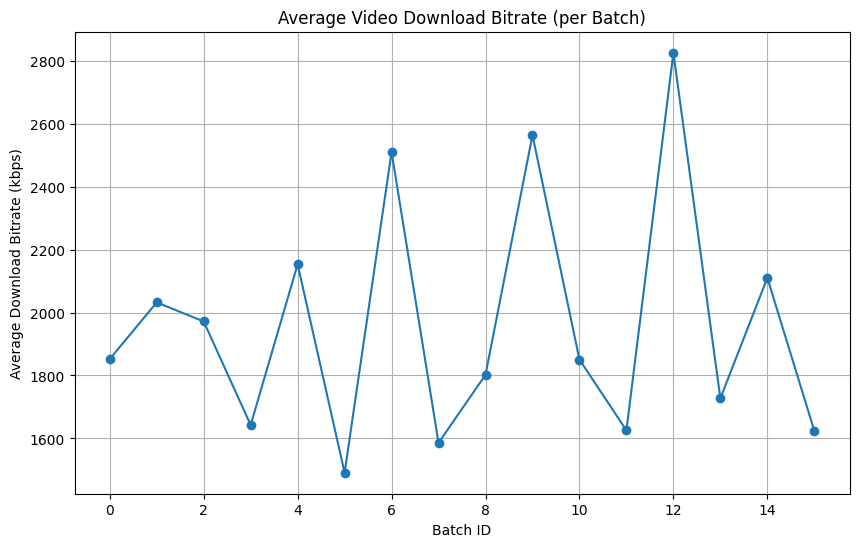

(1960.6106824070198, 1851.357452053494, 376.7251330747495)

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def read_and_analyze_file(file_path):
    batch_ids = []
    avg_download_rates = []

    # Read file
    with open(file_path, 'r') as file:
        data = file.read().strip()

    # Split data into entries
    entries = data.split(',')

    for entry in entries:
        if entry:
            batch_id, avg_rate = entry.split(':')
            batch_ids.append(int(batch_id))
            avg_download_rates.append(float(avg_rate) / 1024)

    # Basic Statistical Analysis
    mean_download_rate = np.mean(avg_download_rates)
    median_download_rate = np.median(avg_download_rates)
    std_dev_download_rate = np.std(avg_download_rates)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(batch_ids, avg_download_rates, marker='o')
    plt.title('Average Video Bitrate (per Batch)')
    plt.xlabel('Batch ID')
    plt.ylabel('Average Video Bitrate (kbps)')
    plt.grid(True)
    plt.show()

    return mean_download_rate, median_download_rate, std_dev_download_rate

file_path = 'average_video_bit_rates.txt'
mean_rate, median_rate, std_dev_rate = read_and_analyze_file(file_path)

mean_rate, median_rate, std_dev_rate